In [3]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import os

OSError: dlopen(/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

# 数据导入与特征提取
+ 1. 删除无所谓的特征"Id"
+ 2. 删除一些值中的异常点（通过画图等分析一下），删除行的时候注意要重新排列一下索引  
train.reset_index(drop=True,inplace=True)  
+ 3. 改写原始train.csv test.csv中的特征列，得到train_features、y和 test_features  
+ 4. 合并上述train_features 与 test_features    
+ 5. 进行特征处理  
    + __填充空值__  
        1. 特定str 填充   
        2. 众数填充   
        3. 0/'None'填充   
        4. groupby分组后对各组中的某一列进行该组内该列的众数/中位数 填充（其中与transform组合使用）   
        5. object对象列中的缺失值填充为'None'   
        6. 对于整型和浮点型数据列，使用0填充其中的空值。  

    + __数值型数据列偏度矫正__  
        1. 对高偏度数据进行处理，将其转化为正态分布。  
    + __特征融合__  
        1. 特征删除  
        2. 融合创建新特征    
        3. 简化特征  
        4. 特征投影、特征矩阵拆解和截取、剔除  
        
            a. 特征投影:get_dummies(）  
            b. 特征矩阵拆解和截取: 恢复trian test  
            c. 剔除X阵和y阵中有着极端值的各行数据  
            d. 剔除过拟合列：某一列中的某个值出现的次数除以特征矩阵的列数超过99.94%，即其几乎在被投影的各个维度上都有着同样的取值，并不具有“主成分”的性质，则记为过拟合列。
        


In [5]:
#######################################################数据导入和特征提取-【开始】################################################################################
#显示当前编译器的Draft Environment下的文件；将文件夹下的对应名称csv文件储存为矩阵对象。

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

#显示矩阵对象的维数，核查是否导入成功
print("Train set size:", train.shape)
print("Test set size:", test.shape)

#记录运算开始的时间
print('START data processing', datetime.now(), )

Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2021-03-26 21:35:20.179173


In [6]:
#将train矩阵中的'Id'列删除（原地删除，故将inplace设为true），因为原始数据中的数据索引和预测模型的构建没有关系。
#test矩阵类似。
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Text(0.5, 0, 'GrLivArea')

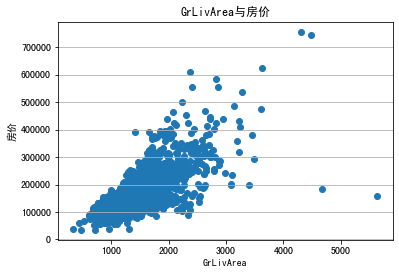

In [12]:
# 看一些数据
import matplotlib.pyplot as plt 
fig=plt.figure()
fig.set(alpha=0.2)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.scatter(train.GrLivArea,train.SalePrice)
plt.title(u"GrLivArea与房价") # puts a title on our graph
plt.grid(b=True, which='major', axis='y') 
plt.ylabel(u"房价")  
plt.xlabel(u"GrLivArea")  



In [ ]:
# 使用条件筛选操作，通过覆值的方式剔除原始数据train矩阵中的极端值（极端值也被称为outliers），帮助预防房价预测模型出现过拟合。剔除操作也可以视为前剪枝。 
train=train[train.GrLivArea<4500]
#由于删去了部分行，故此时train矩阵中的index列并不连续。使用reset_index命令，在固定非index数据的顺序的前提下（inplace=True），重新对index编号（drop=True）。
train.reset_index(drop=True, inplace=True)

In [13]:
##########对预测目标数值进行对数变换和特征矩阵对象的创建-【开始】#######

# log1p就是log(1+x)，用来对房价数据进行数据预处理，它的好处是转化后的数据更加服从高斯分布，有利于后续的分类结果。
# 需要注意，最后需要将预测出的平滑数据还原，而还原过程就是log1p的逆运算expm1。
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True) 

Text(0.5, 0, 'GrLivArea')

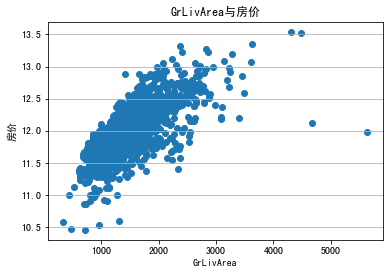

In [14]:
# 再看一下log变换后的数值分布情况
import matplotlib.pyplot as plt 
fig=plt.figure()
fig.set(alpha=0.2)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.scatter(train.GrLivArea,train.SalePrice)
plt.title(u"GrLivArea与房价") # puts a title on our graph
plt.grid(b=True, which='major', axis='y') 
plt.ylabel(u"房价")  
plt.xlabel(u"GrLivArea")  

In [15]:
# train的特征列
train_features = train.drop(['SalePrice'], axis=1)
#test本来就没有房价列，所以它本来就是单纯的特征矩阵。
test_features = test

In [16]:
# 合并处理后的train与test一起处理
features= pd.concat([train_features,test_features]).reset_index(drop=True)
print("剔除训练数据中的极端值后，将其特征矩阵和测试数据中的特征矩阵合并，维度为:",features.shape)


剔除训练数据中的极端值后，将其特征矩阵和测试数据中的特征矩阵合并，维度为: (2919, 79)


In [17]:
features['MSSubClass'].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [ ]:
##############################################################特征处理-【开始】###################################################################################

In [18]:

#对于列名为'MSSubClass'、'YrSold'、'MoSold'的特征列，将列中的数据类型转化为string格式。
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [21]:
features['Functional']

0       Typ
1       Typ
2       Typ
3       Typ
4       Typ
       ... 
2914    Typ
2915    Typ
2916    Typ
2917    Typ
2918    Typ
Name: Functional, Length: 2919, dtype: object

In [23]:
#判断出features矩阵中列为对象的列，将列名存入objects叔祖。对于features矩阵中的各个列对象，将其列中的空值填充为'None'
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
print(len(objects))

46


In [24]:
###############################填充空值-【开始】##########################
# 1. 特定str 填充 2. 众数填充 3. 0/'None'填充 4. groupby分组后对各组中的某一列进行该组内该列的众数/中位数 填充（其中与transform组合使用） 5. object对象列中的缺失值填充为'None' 6. 对于整型和浮点型数据列，使用0填充其中的空值。
#按照以下各个特征列的实际情况，依次处理各个特征列中的空值（.fillna()方法）
features['Functional'] = features['Functional'].fillna('Typ') #空值填充为str型数据'Typ'
features['Electrical'] = features['Electrical'].fillna("SBrkr") #空值填充为str型数据"SBrkr"
features['KitchenQual'] = features['KitchenQual'].fillna("TA") #空值填充为str型数据"TA"
features["PoolQC"] = features["PoolQC"].fillna("None") #空值填充为str型数据"None"

#对于列名为'Exterior1st'、'Exterior2nd'、'SaleType'的特征列，使用列中的众数填充空值。
#	1.先查找数据列中的众数：使用df.mode()[]方法
#	  解释：df.mode(0或1,0表示对列查找，1表示对行查找)[需要查找众数的df列的index（就是df中的第几列）]，将返回数据列中的众数
#	2.使用.fillna()方法进行填充
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])  # ()默认是0,d代表列
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

#对于列名为'GarageYrBlt', 'GarageArea', 'GarageCars'的特征列，使用0填充空值。
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

#对于列名为'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'的特征列，使用字符串'None'填充空值。
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

#对于列名为'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'的特征列，使用字符串'None'填充空值。
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')


#聚合函数（按某一列关键字分组）groupby，它的特点是：将返回与传入方法的矩阵维度相同的单个序列。
#transform是与groupby（pandas中最有用的操作之一）通常组合使用，它对传入方法的矩阵进行维度不变的变换。具体变换方法写在括号中，通常会使用匿名函数，对传入矩阵的所有元素进行操作。
#对于features矩阵，按照'MSSubClass'列中的元素分布进行分组，被分组的数据列是'MSZoning'列。feature.groupby(被作为索引的列的名称)[被分组的数据列的名称]
#features.groupby('MSSubClass')['MSZoning']后，得到的是一个以'MSSubClass'为索引，以'MSZoning'为数据列的矩阵。
#.transform()方法将对'MSZoning'数据列进行()内的变换，它将返回和传入矩阵同样维度的矩阵。
#括号内是匿名函数，将对传入矩阵中的空值进行填充，使用的填充元素是传入矩阵中的众数。
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


#判断出features矩阵中列为对象的列，将列名存入objects叔祖。对于features矩阵中的各个列对象，将其列中的空值填充为'None'
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

#使用传入矩阵（'LotFrontage'列）的中位数对传入矩阵中的空值进行填充。
#先以'Neighborhood'为标签，以'LotFrontage'为被汇总序列。然后使用被汇总序列中的中位数，对原始矩阵'LotFrontage'列中的空值进行填充。
#transform的特性是同维操作，最后输出结果的顺序和原始数据在序号上完全匹配。
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


#对于整型和浮点型数据列，使用0填充其中的空值。
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


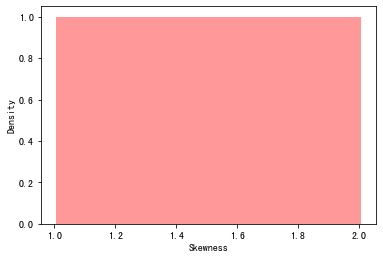

In [27]:
######################数字型数据列偏度校正-【开始】#######################
#使用skew()方法，计算所有整型和浮点型数据列中，数据分布的偏度（skewness）。

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

import seaborn as sns
for numerics in numerics2:
    sns.distplot(features[numerics].skew(),color='red',axlabel="Skewness")
    break

In [28]:
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
#以0.5作为基准，统计偏度超过此数值的高偏度分布数据列，获取这些数据列的index。
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

#对高偏度数据进行处理，将其转化为正态分布。
#Box和Cox提出的变换可以使线性回归模型满足线性性、独立性、方差齐次以及正态性的同时，又不丢失信息。
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))#这是boxcox1p的使用方法，参数的具体意义暂时不解释


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [29]:
skew_features # 列们的偏度

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
dtype: float64

In [36]:
features[['YearBuilt']]


,YearBuilt
0,2003
1,1976
2,2001
3,1915
4,2000
...,...
2914,1970
2915,1970
2916,1960
2917,1992


In [37]:
features[['YearRemodAdd']]

,YearRemodAdd
0,2003
1,1976
2,2002
3,1970
4,2000
...,...
2914,1970
2915,1970
2916,1996
2917,1992


In [38]:
######################特征删除和融合创建新特征-【开始】###################
#删除一些特征。df.drop（‘列名’, axis=1）代表将‘列名’对应的列标签（们）沿着水平的方向依次删掉。
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

#融合多个特征，生成新特征。
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


In [40]:
features[['YrBltAndRemod']] # 就是求和

,YrBltAndRemod
0,4006
1,3952
2,4003
3,3885
4,4000
...,...
2914,3940
2915,3940
2916,3956
2917,3984


In [41]:
#简化特征。对于某些分布单调（比如100个数据中有99个的数值是0.9，另1个是0.1）的数字型数据列，进行01取值处理。
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#检查特征处理后，特征矩阵的维数，核查特征处理结果。
print("删除了3个特征，又融合创建了10个新特征，处理之后的特征矩阵维度为:",features.shape)

删除了3个特征，又融合创建了10个新特征，处理之后的特征矩阵维度为: (2919, 86)


In [42]:
####################特征投影、特征矩阵拆解和截取-【开始】#################
#使用.get_dummies()方法对特征矩阵进行类似“坐标投影”操作。获得在新空间下的特征表达。
final_features = pd.get_dummies(features).reset_index(drop=True)
print("使用get_dummies()方法“投影”特征矩阵，即分解出更多特征，得到更多列。投影后的特征矩阵维度为:",final_features.shape)


使用get_dummies()方法“投影”特征矩阵，即分解出更多特征，得到更多列。投影后的特征矩阵维度为: (2919, 334)


In [43]:
final_features.head() # 默认one-hot化的列名为xxx_yy

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,14.663551,13.424521,7,3.989638,2003,2003,19.378556,117.855851,0.0,30.016555,...,0,0,0,1,0,0,0,0,1,0
1,16.494889,13.694527,6,5.996435,1976,1976,0.000000,146.805782,0.0,44.178889,...,0,0,0,1,0,0,0,0,1,0
2,15.044953,14.034133,7,3.989638,2001,2002,17.721067,91.575275,0.0,56.957796,...,0,0,0,1,0,0,0,0,1,0
3,14.008495,13.683421,7,3.989638,1915,1970,0.000000,52.776363,0.0,64.881737,...,0,0,0,1,1,0,0,0,0,0
4,16.954474,14.550142,8,3.989638,2000,2000,25.323124,112.040313,0.0,61.233859,...,0,0,0,1,0,0,0,0,1,0


In [44]:
#进行特征空间降阶。截取前len(y)行，存入X阵（因为之前进行了训练数据和测试数据的合并，所以从合并矩阵中取出前len(y)行，就得到了训练数据集的处理后的特征矩阵）。
#截取剩余部分，即从序号为len(y)的行开始，至矩阵结尾的各行，存入X_sub阵。此为完成特征变换后的测试集特征矩阵。
#注：len(df)是行计数方法
X = final_features.iloc[:len(y), :]	#y是列向量，存储了训练数据中的房价列信息。截取后得到的X阵的维度是len(y)*(final_features的列数)。
X_sub = final_features.iloc[len(y):, :]#使用len命令，求矩阵X的长度，得到的是矩阵对象的长度，即有矩阵中有多少列，而不是每列上有多少行。
print("删除了3个特征，又融合创建了10个新特征，处理之后的特征矩阵维度为:",'X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)



删除了3个特征，又融合创建了10个新特征，处理之后的特征矩阵维度为: X (1460, 334) y (1460,) X_sub (1459, 334)


In [45]:
#在新生特征空间中，剔除X阵和y阵中有着极端值的各行数据（因为X和y阵在水平方向上是一致的，所以要一起删除同样的行）。outliers数值中给出了极端值的列序号。
#df.drop(df.index[序号])将删除指定序号的各行。再使用=对df覆值。
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])#因为X阵是经过对特征矩阵进行类似“坐标投影”操作后得到的，列向量y中的行号对应着X阵中的列号。
y = y.drop(y.index[outliers])

In [46]:
######################消除截取后特征矩阵的过拟合-【开始】####################### 

# 这一步的目的是处理X阵和X_sub阵。
#在新生特征空间中，删除将产生过拟合的数据列。

#这种数据列具有如下特征：
overfit = []#用来记录产生过拟合的数据列的序号
for i in X.columns:#遍历截取后特征矩阵的每一列
    counts = X[i].value_counts()#使用.value_counts()方法，查看在X矩阵的第i列中，不同的取值分别出现了多少次，默认按次数最高到最低做降序排列。返回一个df。
    zeros = counts.iloc[0]#通过行号索引行数据，取出counts列中第一个元素，即出现次数最多的取值到底是出现了多少次，存入zeros
    if zeros / len(X) * 100 > 99.94:
#判断某一列是否将产生过拟合的条件：
#截取后的特征矩阵有len(X)列，如果某一列中的某个值出现的次数除以特征矩阵的列数超过99.94%，即其几乎在被投影的各个维度上都有着同样的取值，并不具有“主成分”的性质，则记为过拟合列。
        overfit.append(i)

#找到将产生过拟合的数据列的位置后，在特征矩阵中进行删除操作。
overfit = list(overfit)
#overfit.append('MSZoning_C (all)')#这条语句有用吗？是要把训练数据特征矩阵X中的列标签为'MSZoning_C (all)'的列也删除吗？但是训练数据中并没有任何一个列标签名称为MSZoning_C (all)。
X = X.drop(overfit, axis=1)#.copy()#删除截取后特征矩阵X中的过拟合列。因为drop并不影响原数据，所以使用copy。直接覆值应该也可以。
X_sub = X_sub.drop(overfit, axis=1)#.copy()
######################消除截取后特征矩阵的过拟合-【结束】#######################

print("删除极端值及过拟合列后，训练数据特征矩阵的维数为，特征：",'X', X.shape, '对应于特征的对数变换后的房价y', y.shape, '测试数据的特征矩阵（它应该在行、列上未被删减）X_sub', X_sub.shape)
print('特征处理已经完成。开始对训练数据进行机器学习', datetime.now())

删除极端值及过拟合列后，训练数据特征矩阵的维数为，特征： X (1455, 333) 对应于特征的对数变换后的房价y (1455,) 测试数据的特征矩阵（它应该在行、列上未被删减）X_sub (1459, 333)


# 机器学习-【开始】
  # 单个模型
1. 定义交叉验证参数+ 误差函数+ 模型评分函数  
2. 定义多个模型的参数以及对模型进行设置  
3. 集成多个个体学习器  
4. __进行交叉验证打分__  
  （其实就是使用训练数据特征矩阵作为输入，训练数据对数处理后的预测房价作为输出，进行各个模型的训练）  
    
    # 融合集成
5. 定义个体学习器的预测值融合函数，检测预测值融合策略的效果  
    1. 训练上述模型（这次不是交叉验证训练了，是直接训练）
    2. 融合多个模型的预测值，作为多模型组合学习器的预测值   
         打印上述模型的均方根对数误差   
    3. 使用训练数据对上述创造的模型进行k折交叉验证，以训练创造出的模型的参数配置。
    4. 交叉验证训练过程结束后，将得到模型的参数配置。使用得出的参数配置下，在全体训练数据上进行验证，验证模型对全体训练数据重构的误差。  
    5. 将测试集的特征矩阵作为输入，传入训练好的模型，得出的输出写入.csv文件的第2列  
      
  # 抄抄答案哈哈哈哈

In [54]:
# k折交叉验证参数
kfolds = KFold(n_splits=10,shuffle=True,random_state=42)

# 定义均方根对数误差（Root Mean Squared Logarithmic Error ，RMSLE)
def rmsle ( y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

# 创建模型评分函数，根据不同模型的表现打分
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [50]:
#############个体机器学习模型的创建（即模型声明和参数设置）-【开始】############
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

#定义ridge岭回归模型（使用二范数作为正则化项。不论是使用一范数还是二范数，正则化项的引入均是为了降低过拟合风险。）
#注：正则化项如果使用二范数，那么对于任何需要寻优的参数值，在寻优终止时，它都无法将某些参数值变为严格的0，尽管某些参数估计值变得非常小以至于可以忽略。即使用二范数会保留变量的所有信息，不会进行类似PCA的变量凸显。
#注：正则化项如果使用一范数，它比L2范数更易于获得“稀疏(sparse)”解，即它的求解结果会有更多的零分量。
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

#定义LASSO收缩模型（使用L1范数作为正则化项）（由于对目标函数的求解结果中将得到很多的零分量，它也被称为收缩模型。）
#注：正则化项如果使用二范数，那么对于任何需要寻优的参数值，在寻优终止时，它都无法将某些参数值变为严格的0，尽管某些参数估计值变得非常小以至于可以忽略。即使用二范数会保留变量的所有信息，不会进行类似PCA的变量凸显。
#注：正则化项如果使用一范数，它比L2范数更易于获得“稀疏(sparse)”解，即它的求解结果会有更多的零分量。										
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

#定义elastic net弹性网络模型（弹性网络实际上是结合了岭回归和lasso的特点，同时使用了L1和L2作为正则化项。）									
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

#定义SVM支持向量机模型                                     
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

#定义GB梯度提升模型（展开到一阶导数）									
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

# #定义lightgbm模型									
# lightgbm = LGBMRegressor(objective='regression', 
#                                        num_leaves=4,
#                                        learning_rate=0.01, 
#                                        n_estimators=5000,
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,
#                                        #min_data_in_leaf=2,
#                                        #min_sum_hessian_in_leaf=11
#                                        )

#定义xgboost模型（展开到二阶导数）                                      
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [59]:
###########################集成多个个体学习器-【开始】##########################
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, svr,xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)#regressors=(...)中并没有纳入前面的svr模型

# 交叉验证对单个模型打分

In [55]:
#进行交叉验证，并对不同模型的表现打分
#（由于是交叉验证，将使用不同的数据集对同一模型进行评分，故每个模型对应一个得分序列。展示模型得分序列的平均分、标准差）
print('进行交叉验证，计算不同模型的得分TEST score on CV')
#打印二范数rideg岭回归模型的得分
score = cv_rmse(ridge)
print("二范数rideg岭回归模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印一范数LASSO收缩模型的得分
score = cv_rmse(lasso)
print("一范数LASSO收缩模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印elastic net弹性网络模型的得分
score = cv_rmse(elasticnet)
print("elastic net弹性网络模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印SVR支持向量机模型的得分
score = cv_rmse(svr)
print("SVR支持向量机模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# #打印lightgbm轻梯度提升模型的得分
# score = cv_rmse(lightgbm)
# print("lightgbm轻梯度提升模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印gbr梯度提升回归模型的得分
score = cv_rmse(gbr)
print("gbr梯度提升回归模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#打印xgboost模型的得分
score = cv_rmse(xgboost)
print("xgboost模型的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )
############################进行交叉验证打分-【结束】###########################



进行交叉验证，计算不同模型的得分TEST score on CV
二范数rideg岭回归模型的得分: 0.1227 (0.0443)
 2021-03-27 09:52:01.492888
一范数LASSO收缩模型的得分: 0.1201 (0.0429)
 2021-03-27 09:52:08.518390
elastic net弹性网络模型的得分: 0.1196 (0.0431)
 2021-03-27 09:52:36.364700
SVR支持向量机模型的得分: 0.1184 (0.0459)
 2021-03-27 09:52:45.707154
gbr梯度提升回归模型的得分: 0.1232 (0.0367)
 2021-03-27 09:54:03.382197
[09:54:03] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
[09:54:14] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it w

In [60]:
#########使用训练数据特征矩阵作为输入，训练数据对数处理后的预测房价作为输出，进行各个模型的训练-【开始】#########
#开始集合所有模型，使用stacking方法
print('进行模型参数训练 START Fit')

print(datetime.now(), '对stack_gen集成器模型进行参数训练')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print(datetime.now(), '对elasticnet弹性网络模型进行参数训练')
elastic_model_full_data = elasticnet.fit(X, y)

print(datetime.now(), '对一范数lasso收缩模型进行参数训练')
lasso_model_full_data = lasso.fit(X, y)

print(datetime.now(), '对二范数ridge岭回归模型进行参数训练')
ridge_model_full_data = ridge.fit(X, y)

print(datetime.now(), '对svr支持向量机模型进行参数训练')
svr_model_full_data = svr.fit(X, y)

print(datetime.now(), '对GradientBoosting梯度提升模型进行参数训练')
gbr_model_full_data = gbr.fit(X, y)

print(datetime.now(), '对xgboost二阶梯度提升模型进行参数训练')
xgb_model_full_data = xgboost.fit(X, y)

# print(datetime.now(), '对lightgbm轻梯度提升模型进行参数训练')
# lgb_model_full_data = lightgbm.fit(X, y)

进行模型参数训练 START Fit
2021-03-27 10:09:18.419287 对stack_gen集成器模型进行参数训练
[10:10:22] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:31] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:39] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:48] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:56] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:04] WARNING: /Users/wangluya/code/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:27] WARNING: /Users/wangluya/code/xgboost/src/objective

# 融合模型  
__包括各个单独模型+stack模型的 配比结果__


In [61]:
########定义个体学习器的预测值融合函数，检测预测值融合策略的效果-【开始】#######
#综合多个模型产生的预测值，作为多模型组合学习器的预测值

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.25 * xgb_model_full_data.predict(X)) + \
            # (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))
            
#打印在上述模型配比下，多模型组合学习器的均方根对数误差（Root Mean Squared Logarithmic Error ，RMSLE）
#使用训练数据对创造的模型进行k折交叉验证，以训练创造出的模型的参数配置。交叉验证训练过程结束后，将得到模型的参数配置。使用得出的参数配置下，在全体训练数据上进行验证，验证模型对全体训练数据重构的误差。
print('融合后的训练模型对原数据重构时的均方根对数误差RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))





融合后的训练模型对原数据重构时的均方根对数误差RMSLE score on train data:
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
0.058477198852928874
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [62]:
########将测试集的特征矩阵作为输入，传入训练好的模型，得出的输出写入.csv文件的第2列-【开始】########
print('使用测试集特征进行房价预测 Predict submission', datetime.now(),)
submission = pd.read_csv("./data/sample_submission.csv")
#函数注释：.iloc[:,1]是基于索引位来选取数据集，[索引1:索引2]，左闭右开。
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))


使用测试集特征进行房价预测 Predict submission 2021-03-27 10:33:58.790783
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


# 抄抄人家的答案哈哈哈哈哈！可不可以只抄答案哈哈哈哈哈！
对结果的极大极小值处理一下

In [ ]:
######################模型输出结果融合-【开始】#############################
#在多模型集成学习器预测结果的基础上，融合其他优秀模型（即平台上其他均方根对数误差小的模型）的预测结果。
#这步操作是为了降低多模型集成学习器的方差。
print('融合其他优秀模型的预测结果 Blend with Top Kernals submissions', datetime.now(),)
sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))
######################模型输出结果融合-【结束】#############################      

####################融合结果的极端值剔除-【开始】###########################  
#处理融合后结果中的极端值。把太大的数值（降序排列时，位于顶部往下0.005的数值，就是只有0.005的数比它大）缩小一点（乘以0.77），把太小的数值（降序排列时，位于顶部往下0.99的数值）放大一点（乘以1.1）
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
####################融合结果的极端值剔除-【结束】###########################

#以csv文件的形式输出预测值
submission.to_csv("House_price_submission.csv", index=False)
print('融合结果.csv文件输出成功 Save submission', datetime.now())
##############################################################机器学习-【结束】###################################################################################